# Face or Not

#### Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision
import matplotlib.pyplot as plt
from matplotlib import image
from PIL import Image
import cv2
import os
import numpy as np
import random
from random import randrange
import math

#### Configure Device

In [3]:
dev = torch.device('cpu')

#### Build Dataset

In [4]:
image_shape = (32, 32)

In [5]:
# removes incorect files from an array of paths
def remove_ds(files):
    for f in files:
        if '.DS' in f:
            files.remove(f)
        if '.ipynb' in f:
            files.remove(f)
    return files

# read an image from a path to a tensor and put it in the correct format
def load_image_to_tensor_resize(path):
    img = image.imread(path)
    resize = cv2.resize(img, image_shape)
    tensor = torch.tensor(resize, device=dev)
    # put in N Channel Height Width format!
    permute = tensor.permute(2,0,1)
    return permute

# show an example from a dataset at a given index
def show_example(dataset, idx):
    idx_x, idx_y = dataset.__getitem__(idx)
    title = '\033[92m Person \033[0m' if idx_y == 1 else '\033[93m Not a Person \033[0m'
    print(title)
    plt.imshow(idx_x.cpu().permute(1,2,0).int())
    plt.show()

In [110]:
# Creates a Dataset for use with a DataLoader
# Reads all images in a given folder into a dataset with given parameters
class FaceOrNotDataset(torch.utils.data.Dataset):
    
    def __init__(self, people_dir, not_people_dir):
        '''generate examples based on files'''
        x = np.array([[]])
        y = np.array([]) # 1 = person; 0 = not-person
        
        people_images_paths = remove_ds(os.listdir(people_dir))
        not_people_images_paths = remove_ds(os.listdir(not_people_dir))
        
        for person_path in people_images_paths:
            x = np.append(x, [people_dir + '/' + person_path])
            y = np.append(y, [1])

        for not_person_path in not_people_images_paths:
            x = np.append(x, [not_people_dir + '/' + not_person_path])
            y = np.append(y, [-1])
        
        self.x = x
        self.y = y
        
    
    def __len__(self):
        # return the number of examples
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        # make the example for the index
        idx_x = load_image_to_tensor_resize(self.x[idx])
        idx_y = self.y[idx]
        return idx_x.float(), torch.Tensor([idx_y]).float()
    
    def get_x_length(self):
        return self.x.shape[0]
    
    def get_y_length(self):
        return self.y.shape[0]
    
    def get_x(self, idx):
        return self.x[idx]

#### Generate Training Data

In [111]:
train_dataset = FaceOrNotDataset('Faces/Train', 'NotFaces/Train')

In [112]:
test_dataset = FaceOrNotDataset('Faces/Test', 'NotFaces/Test')

In [114]:
print(train_dataset.__len__())
print(test_dataset.__len__())
f = 0
nf = 0
for i in range(train_dataset.__len__()):
    x, y = train_dataset.__getitem__(i)
    if y == -1:
        nf += 1
    else:
        f += 1
print('Positive Training Examples: ' + str(f))
print('Negative Training Examples ' + str(nf))

4183
89
Positive Training Examples: 1276
Negative Training Examples 2907


 Not a Person 


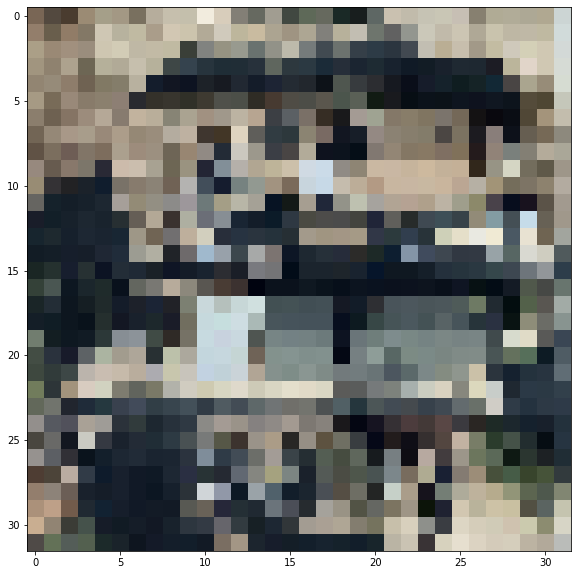

NotFaces/Train/000002524.jpg
torch.Size([3, 32, 32])


In [117]:
ds = train_dataset
idx = randrange(ds.__len__())
show_example(ds, idx)
print(ds.get_x(idx))
x, y = ds.__getitem__(idx)
print(x.shape)


In [25]:
for idx in range(train_dataset.__len__()):
    x, y = train_dataset.__getitem__(idx)
    ch = x.shape[0]
    if ch != 3:
        print(idx)

#### Build Model

In [118]:
# Define the model
# 3 convolutional layers followed by 2 fully connected layers
class NFNet(nn.Module):
    def __init__(self):
        super(NFNet, self).__init__()
        # layer 1
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5, padding = 1)
        self.a1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size = 2)
        #norm???
        # layer 2
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 12, kernel_size = 5, padding = 1)
        self.a2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size = 2)
        # layer 3
        self.conv3 = nn.Conv2d(in_channels = 12, out_channels = 24, kernel_size = 3, padding = 1)
        self.a3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size = 4)
        #linear
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features = 24, out_features = 1)
        self.a4 = nn.ReLU()
#         self.fc2 = nn.Linear(in_features = 32, out_features = 1)
#         self.a5 = nn.ReLU()
    

    def forward(self, x):
        # layer 1
        x = self.conv1(x)
        x = self.a1(x)
        x = self.pool1(x)
        
#         # layer 2
        x = self.conv2(x)
        x = self.a2(x)
        x = self.pool2(x)
        
        #layer 3
        x = self.conv3(x)
        x = self.a3(x)
        x = self.pool3(x)
        
        #linear
        x = self.flatten(x)
#         print(x.shape)
        x = self.fc1(x)
#         x = self.a4(x)
#         x = self.fc2(x)
        x = torch.tanh(x)
        return(x)



In [119]:
model = NFNet()
model = model.to(dev)

 Correct 
Y: 1.0 Y^: 0.99290675


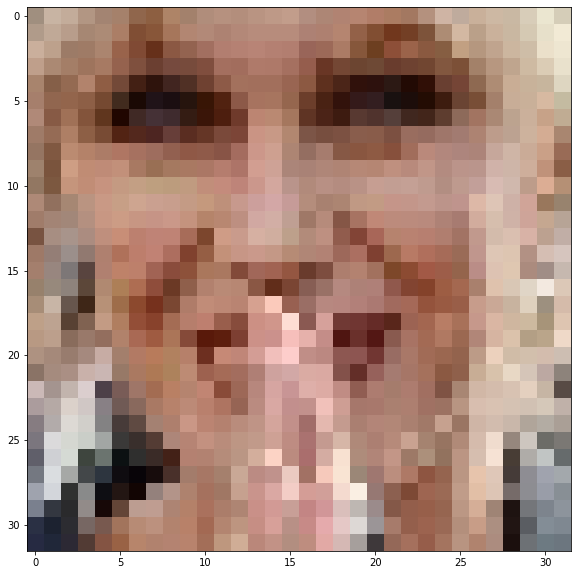

In [136]:
def test_example(dataset, idx, m):
    x, y = dataset.__getitem__(idx)
    inpt = torch.unsqueeze(x, 0)
    y_hat = model(inpt.float())
    y = y.cpu().detach().numpy()[0]
    y_hat = y_hat.cpu().detach().numpy()[0][0]
    title = '\033[92m Correct \033[0m' if round(y_hat) == y else '\033[93m Wrong \033[0m'
    print(title)
    print('Y: ' + str(y) + ' Y^: ' + str(y_hat))
    plt.imshow(x.cpu().permute(1,2,0).int())
    plt.show()

test_example(train_dataset, randrange(train_dataset.__len__()), model)

In [137]:
batch_size = 8
num_epochs = 2
# learning_rate = 0.01

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
optimizer = optim.Adadelta(model.parameters(), weight_decay = 1e-3)
loss_function = nn.MSELoss(reduction='sum')
model.train()

for epoch in range(num_epochs):
    print('Training Epoch ' + str(epoch + 1) + ' / ' + str( num_epochs), end='\r')
    
    for batch_idx, (mini_x, mini_y) in enumerate(train_loader):
        optimizer.zero_grad()
        mini_y_hat = model(mini_x.to(dev))
        loss = loss_function(mini_y_hat.cpu(), mini_y)
        loss.backward()
        optimizer.step()

optimizer.zero_grad()

In [138]:
    
# Returns the % correct, number negative examples wrong, and the number positive examples wrong
def compute_average_acuracy_for_dataset(ds):
    model.eval()
    test_loader = torch.utils.data.DataLoader(ds, batch_size=64)
    y_hat = torch.Tensor([])
    y = torch.Tensor([])

    for batch_idx, (mini_x, mini_y) in enumerate(test_loader):
        with torch.no_grad():
            mini_y_hat = model(mini_x)
        y_hat = torch.cat((y_hat, mini_y_hat.cpu()))
        y = torch.cat((y, mini_y))

    num_right = 0
    num_neg_wrong = 0
    num_pos_wrong = 0
    for i in range(y.shape[0]):
        if round(y_hat[i].detach().numpy()[0]) == y[i]:
            num_right += 1
        elif y[i] == 0:
            num_neg_wrong += 1
        else:
            num_pos_wrong += 1
    return num_right / y.shape[0] * 100, num_neg_wrong, num_pos_wrong

dataset = train_dataset
# dataset = test_dataset
per, nnw, npw = compute_average_acuracy_for_dataset(dataset)  
print('Accuracy: ' + str(per) + '%' + ' Missed Positives: ' + str(npw) + ' Missed Negatives: ' + str(nnw))



Accuracy: 99.06765479321061% Missed Positives: 39 Missed Negatives: 0


 Correct 
Y: -1.0 Y^: -0.99995625


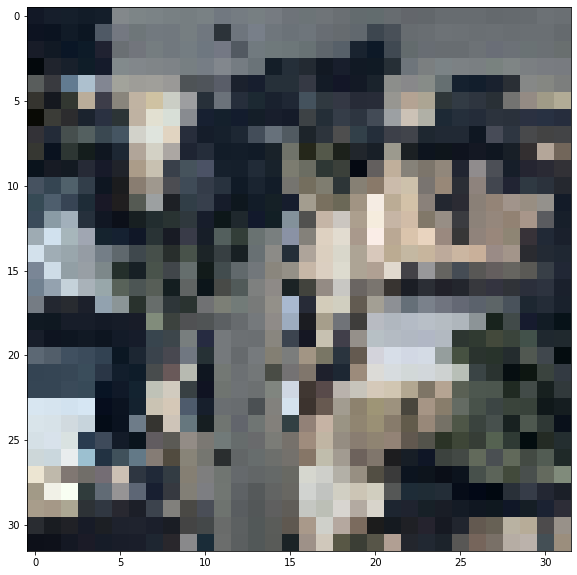

In [145]:
dataset = train_dataset
# dataset = test_dataset
idx = randrange(dataset.__len__())
# idx = 8
test_example(dataset, idx, model)

## Sliding Windows

In [146]:
plt.rcParams["figure.figsize"] = (20,10)

In [147]:
def load_image_to_tensor(path):
    img = image.imread(path)
    tensor = torch.tensor(img.copy(), device=dev)
    # put in N Channel Height Width format!
    permute = tensor.permute(2,0,1)
    return permute

lobby = load_image_to_tensor('TestData/lobby.jpg')

Rows: 566 Columns: 1200
Match Found!! 0.99918133%


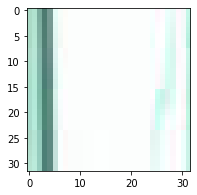

Match Found!! 0.9990416%


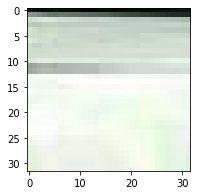

Match Found!! 0.99929726%


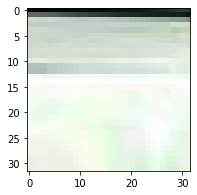

Match Found!! 0.9994575%


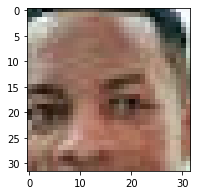

Match Found!! 0.99921066%


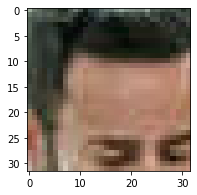

Match Found!! 0.99936175%


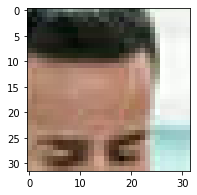

Match Found!! 0.99945974%


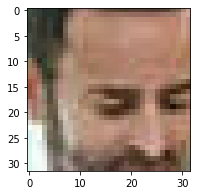

Match Found!! 0.99961317%


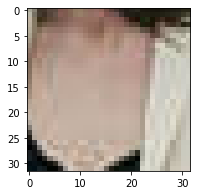

Match Found!! 0.9999113%


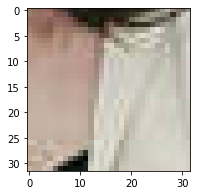

Match Found!! 0.99925834%


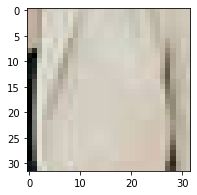

Match Found!! 0.9995245%


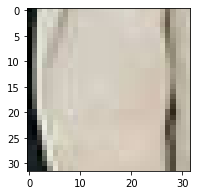

Match Found!! 0.9998657%


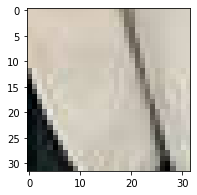

Match Found!! 0.9997276%


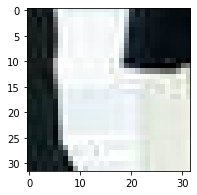

Match Found!! 0.99901515%


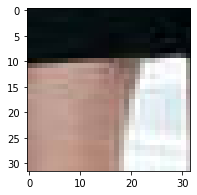

Match Found!! 0.9999824%


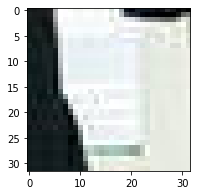

Match Found!! 0.9999208%


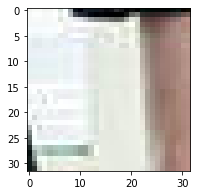

Match Found!! 0.99958855%


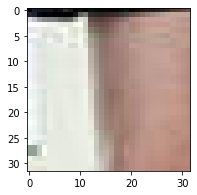

Match Found!! 0.99924237%


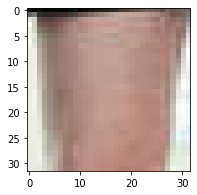

Match Found!! 0.99960446%


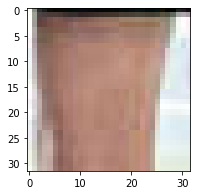

Match Found!! 0.99921125%


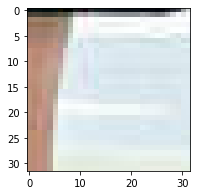

Match Found!! 0.9995966%


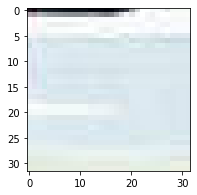

Match Found!! 0.99951833%


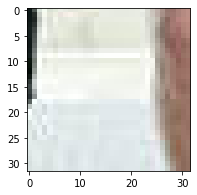

Match Found!! 0.9997975%


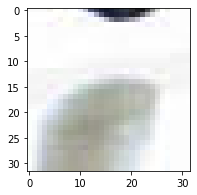

Match Found!! 0.9990615%


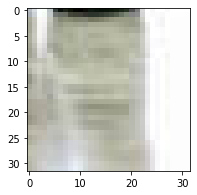

Matched 24/6318


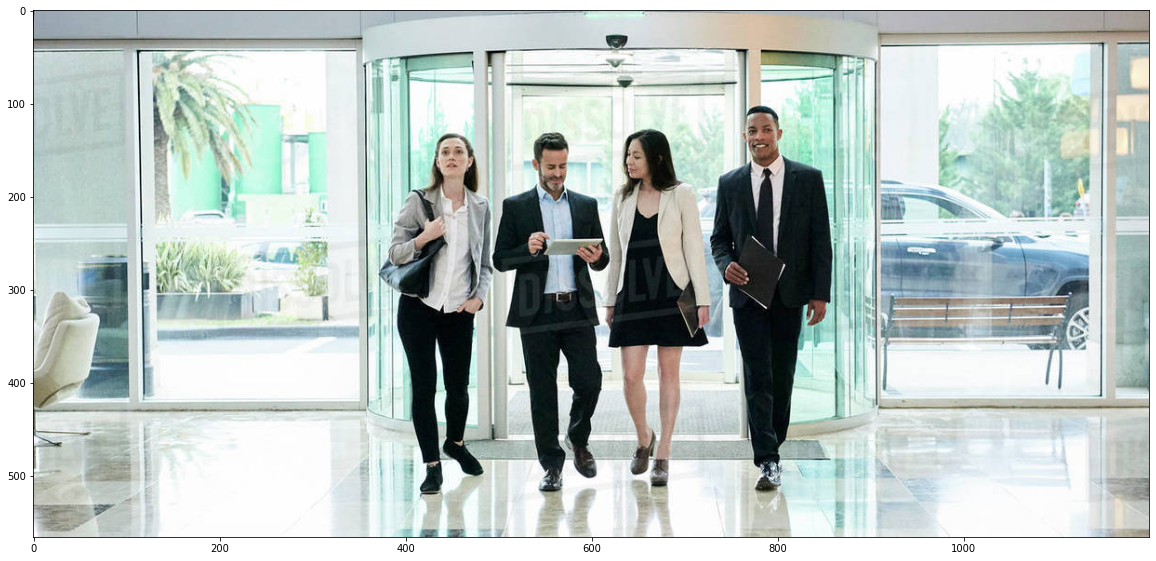

In [152]:


plt.rcParams["figure.figsize"] = (3,3)
def sliding_windows(img):
    
    total_sw = 0
    match_sw = 0


    rows = img.size()[1]
    columns = img.size()[2]
    print('Rows: ' + str(rows) + ' Columns: ' + str(columns))
    
    delta = 10
    length = 32

    r = 0
    while (r) + 32 < rows:
        start_row = r
        end_row = r + 32
        row_slice = img[:,start_row:end_row]
        
        c = 0
        while (c) + 32 < columns:
            start_col = c
            end_col = c + 32
            window = row_slice[:,:,start_col:end_col]
            total_sw += 1
            
            inpt = torch.unsqueeze(window, 0)
            y = model(inpt.to(dev).float())
            if y > 0.999:
                print('Match Found!! ' + str(y.cpu().detach().numpy()[0][0]) + '%')
                plt.imshow(window.cpu().permute(1,2,0).int())
                plt.show()
                match_sw += 1
            
            c += delta
        
        r += delta
    print('Matched ' + str(match_sw) + '/' + str(total_sw))
    plt.rcParams["figure.figsize"] = (20,10)
    plt.imshow(img.cpu().permute(1,2,0).int())
    plt.show()
    
sliding_windows(lobby)
